In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 8-1. 들어가며

- object detection 모델을 통해 주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어 본다.
- 하지만 자율주행 시스템은 아직 완전하지 않기 때문에, 위험한 상황에서는 운전자가 직접 운전할 수 있도록 하거나 판단이 어려운 상황에서는 멈추도록 설계된다.
- 같은 구조를 가진 미니 자율주행 보조장치를 만들어 보자.

<br>

**실습 목표**
1. Object detection 모델을 학습할 수 있다.
2. RetinaNet 모델을 활용한 시스템을 만들 수 있다.

<br>

**학습 내용**
1. 자율주행 보조장치
2. RetinaNet
3. 데이터 준비부터 모델 학습, 결과 확인까지
4. 프로젝트: 자율주행 보조 시스템 만들기



# 8-2. 자율주행 보조장치 (1) KITTI 데이터셋

>자율주행 보조장치 object detection 요구사항<br><br>
1. **사람**이 카메라에 감지되면 <u>정지</u>
2. 차량이 일정 **크기 이상으로 감지되면** <u>정지</u>

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-4-P-passat_sensors.jpg)

<br>

- `tensorflow_datasets`에서 제공하는 KITTI 데이터셋을 사용
- **KITTI 데이터셋**은 <u>자율주행을 위한 데이터셋</u>으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있다.

<br>

- [cvlibs에서 제공하는 KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)


## 필요한 라이브러리 임포트

In [ ]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/content/drive/MyDrive/아이펠/GOING DEEPER/data/object_detection/data'

print('슝=3')

슝=3


아래 코드를 통해서 KITTI 데이터셋을 다운로드

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


- 다운로드한 KITTI 데이터셋을 `tfds.show_examples`를 통해 샘플확인
- 우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인할 수 있다.

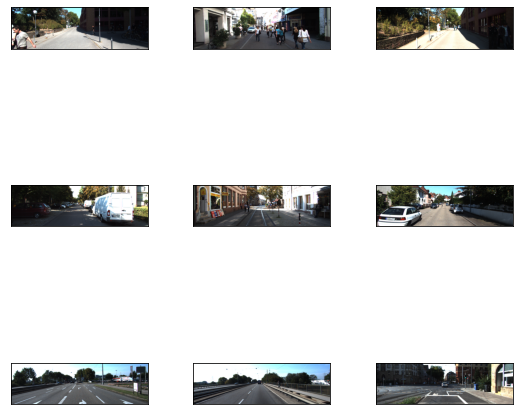

In [ ]:
_ = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 ds_info에서는 불러온 데이터셋의 정보를 확인할 수 있다. 

<br>

- 6,347개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성
- 라벨에는 `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보가 있다.

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

# 8-3. 자율주행 보조장치 (2) 데이터 직접 확인하기


------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([-2.01,  1.92, -1.93, -1.8 , -1.75,  1.65, -1.7 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.18186666, 0.74190015, 0.49984   , 0.8036715 ],
       [0.00266667, 0.08744767, 0.48042667, 0.3595974 ],
       [0.00266667, 0.6150725 , 0.53128   , 0.90697265],
       [0.21274666, 0.574058  , 0.49658668, 0.69640905],
       [0.31757334, 0.54619163, 0.54981333, 0.63347024],
       [0.42213333, 0.41983092, 0.52672   , 0.457971  ],
       [0.41965333, 0.5287842 , 0.55461335, 0.5732367 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.44, 0.36, 1.26],
       [1.46, 1.6 , 3.33],
       [1.64, 1.7 , 3.54],
       [1.37, 1.51, 3.39],
       [1.74, 1.66, 4.23],
       [1.55, 1.68, 4.42],
       [2.  , 1.76, 4.61]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float

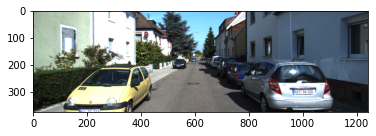

In [ ]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

위 설명과 예시 이미지를 참고하셔서 이미지 위에 바운딩 박스를 그려서 시각화


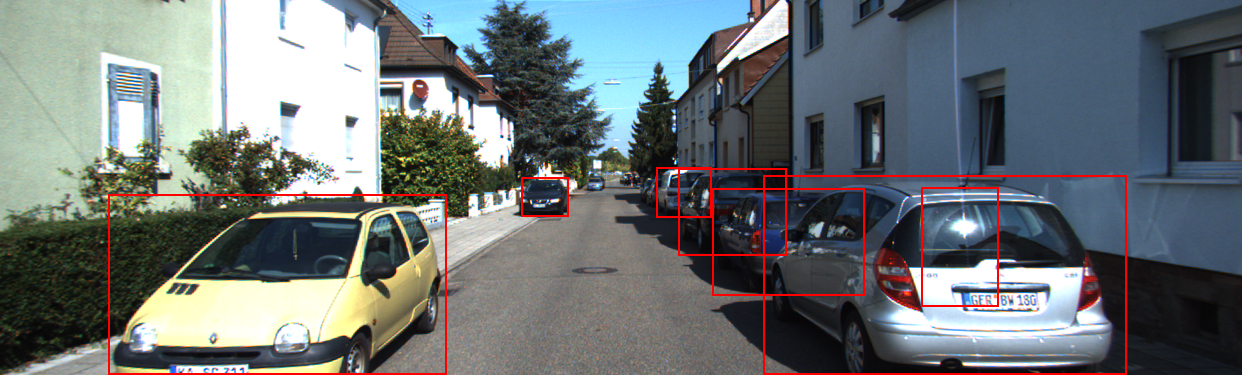

In [ ]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

# 8-4. RetinaNet

- [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)

<br>

RetinaNet은 **Focal Loss for Dense Object Detection** 논문을 통해 공개된 detection 모델이다.

<br>

- 1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었다.
- 이를 해결하기 위해서 RetinaNet에서는 **focal loss**와 **FPN(Feature Pyramid Network)** 를 적용한 네트워크를 사용

**Focal Loss**

> 물체를 배경보다 더 잘 학습하자 == 물체인 경우 Loss를 작게 만들자

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-car.max-800x600.png)

<br>

- Focal loss는 **기존의 1-stage detection 모델들(YOLO, SSD)**이 <u>물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨</u>으로 인해서 생기는 **클래스 간의 불균형을 해결하고자 도입**되었다.
- 여기서 그리드(grid)와 픽셀(pixel)이 혼란스러울 수 있겠는데, 위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field이다.

<br>

- 그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 된다. 
- 논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/focal_loss.png)

<br>

- Focal loss는 우리가 많이 사용해왔던 **교차 엔트로피**를 기반으로 만들어졌다. 
- 위 그림을 보면 Focal loss는 그저 <u>교차 엔트로피 CE($p_t$ )의 앞단에 간단히 $(1-p_t)^\gamma$라는 modulating factor</u>를 붙여주었습니다.

<br>

- 교차 엔트로피의 개형을 보면 **`ground truth class`에 대한 확률이 높으면** <u>잘 분류된 것으로 판단</u>되므로 손실이 줄어든다.
- 하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어진다.

<br>

- 대부분의 이미지에서는 물체보다 배경이 많고, <u>극단적으로 배경의 class가 많은</u> **class imbalanced data**라고 할 수 있다. 
- 이렇게 너무 많은 배경 class에 압도되지 않도록 **modulating factor**로 손실을 조절해준다.
- $\gamma$를 `0`으로 설정하면 modulating factor $(1-p_t)^\gamma$가 1이 되어 일반적인 교차 엔트로피가 되고 <u>**$\gamma$**가 커질수록 modulating이 강하게 적용</u>된다.

**FPN(Feature Pyramid Network)**

> 여러 층의 특성 맵(feature map)을 다 사용해보자

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-fpn.max-800x600.png)

<br>

- FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식 
- CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있다. 
- 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 <u>입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고</u>, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있다. 👉 **receptive field**
- 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 된다.

<br>

- **FPN**은 <u>백본의 **여러 레이어를 한꺼번에 쓰겠다**라는데에 의의</u> 가 있다.
- SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 **RetinaNet**에서는 receptive field가 넓은 <u> 뒷쪽의 특성 맵을 upsampling(확대)하여</u> **앞단의 특성 맵과 더해서 사용**했다. 
- 레이어가 깊어질수록 feature map의 $w, h$방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-FPN.max-800x600.png)

<br>

- 위 그림은 RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지를 설명하는 그림
- RetinaNet에서는 FPN을 통해 $P_3$부터 $P_7$까지의 pyramid level을 생성해서 사용
- 각 pyramid level은 256개의 채널로 이루어져 있다.
- 이를 통해 **Classification Subnet**과 **Box Regression Subnet** 2개의 Subnet을 구성하게 되는데, Anchor 갯수를 $A$라고 하면 최종적으로 Classification Subnet은 $K$개 class에 대해 $KA$개 채널을, Box Regression Subnet은 $4A$개 채널을 사용하게 된다.

# 8-5. 데이터 준비

<br>

**데이터 파이프 라인**

먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸어 주어야 한다. 이때 사용할 데이터 파이프라인을 구축

<br>

데이터 파이프라인은 총 4단계로 이루어진다.

<br>

1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 `[x_min, y_min, x_max, y_max]`에서 `[x_min, y_min, width, height]`으로 수정

<br>

독립적인 함수를 각각 작성

In [ ]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)
    # tf.stack(value, axis) : concat 처럼 tensor를 합치는 건데, 차원을 늘려준다.

print('슝=3')

슝=3


In [ ]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


> ❗이미지의 크기를 바꿀 때 고려할 점❗<br><br>
1. **이미지의 비율** <u>그대로 유지</u>
2. 이미지의 <u>최대/최소 크기도 제한</u>해야 한다.
3. 이미지의 크기를 바꾼 후에도 <u>최종적으로 모델에 입력되는 이미지의 크기는</u> **`stride`의 배수가 되도록** 만들어야 함.

<br>

- 실제로 입력할 이미지를 어떻게 바꿀지는 `min_side`, `max_side`, `min_side_range`, `stride`등에 의해 결정된다.
- 그리고 <u>학습이 완료된 모델을 사용할 때는</u> 입력할 이미지를 다양한 크기로 바꿀 필요는 없으니 분기처리를 해준다.

In [ ]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


In [ ]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


준비된 함수들을 연결해 준다.

In [ ]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


**인코딩**

- **One stage detector**에서는 `Anchor Box`라는 정해져 있는 <u>`위치`, `크기`, `비율` 중에 하나로 물체의 위치가 결정</u>된다. 
- 그래서 기본적으로 Anchor Box를 반드시 생성해줘야 함.
- Anchor Box로 생성되는 것은 **물체 위치 후보**라고 생각하면 된다.

<br>

- RetinaNet에서는 **FPN**을 사용하기 때문에 <u>Anchor Box가 더 많이 필요</u>하다.
- FPN의 각 층마다 Anchor Box가 필요하기 때문
- RetinaNet의 FPN에서 <u>**pyramid level은 개수**가 미리 약속되어 있기 때문에</u> 각 level에서 만들어지는 Anchor Box도 약속되어 있다.

<br>

여기서는 논문과 같은 형태로 Anchor Box를 생성한다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-4-1.png)

In [ ]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형해줘야 한다.

<br>

- 데이터 원본의 `bbox`는 주관식 정답이라고 생각하면 된다.
- 하지만 모델은 객관식으로 문제를 풀어야 하기 때문에 주관식 정답을 가장 가까운 <u>객관식 정답으로 바꿔줘야</u> 모델을 학습시킬 수 있다. 👉 **IoU를 사용**. IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크

In [ ]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


실제 라벨을 Anchor Box에 맞춰주는 클래스를 만들어 본다.

- 위에서 작성한 `compute_iou` 함수를 이용해서 IoU를 구하고 **그 IoU를 기준으로** 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해 준다.
- 그리고 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산
- 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 <u>가로세로 크기는 **로그**를 사용해서 기록</u>해 둔다.

<br>

>이 과정에서 `variance`가 등장하는데 관례적으로 Anchor Box를 사용할 때 등장한다.<br>
어디에도 정확한 이유가 등장하지는 않지만 <u>**상하좌우의 차이**에는 `0.1`, **가로세로 크기의 차이**에는 `0.2`를 사용</u><br>
이와 관련하여 <u>통계적 추정치를 계산할 때</u> 분산으로 나눠주는 것 때문이라는 의견이 있다.

<br>

이 과정은 마치 데이터를 훈련이 가능한 형식으로 encode하는 것 같으니 `LabelEncoder`라는 이름으로 클래스를 만들어 준다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-4-2.png)<br>
[IoU가 0.5보다 높으면 물체, 0.4보다 낮으면 배경입니다]

In [ ]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)    # 가장 match_iou와 비슷한 max_iou를 찾는 메서드
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


이제 데이터를 모델이 학습 가능한 형태로 바꿔 줄 수 있게 되었다.


# 8-6. 모델 작성

**Feature Pyramid**

- RetinaNet에서 사용하는 FPN(Feature Pyramid Network)를 약간 수정해서 사용한다.

자세한 설명은 아래에 나와있다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-5-1.png)<br>
[FPN을 약간 수정합니다]


In [ ]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


- Object Detection의 라벨은 `class`와 `box`로 이루어지므로 각각을 추론하는 부분이 필요. 그것을 `head`라고 한다.
- Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 `class`를 예상하고, `box`도 예상한다.
- class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 둘 다 틀릴 수도 있다.
- **class를 예측하는 `head`**와 **box를 예측하는 `head`**가 별도로 존재한다는 것이 중요

<br>

- 각각의 head를 만들어 준다.
- head부분은 유사한 형태로 만들 수 있으니 `build_head`라는 함수를 하나만 만들고 두 번 호출하면 된다.

In [ ]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


- 이 프로젝트에서 만들 RetinaNet의 backbone은 ResNet50을 사용한다.
- FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해 준다.

In [ ]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


**RetinaNet**

**`Backbone + FPN + classification용 head + box용 head`**

In [ ]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


이제 모델을 준비했고, Loss에 대한 준비를 해 본다.

<br>

- RetinaNet에서는 **Focal Loss**를 사용한다.
- Box Regression에는 사용하지 않고 <u>Classification Loss를 계산하는데만 사용</u>됩니다. 
- Box Regression에는 **Smooth L1 Loss**를 사용

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-5-2.png)

<br>

**Smooth L1 Loss**을 사용하는 **Box Regression**에는 `delta`를 기준으로 계산이 달라지고, **Focal Loss**를 사용하는 **Classification**에서는 `alpha`와 `gamma`를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의❗

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


이제 모든 준비가 끝났습니다. 모델 학습을 할 수 있겠네요!

# 8-7. 모델 학습

앞에서 만들어 놓은 클래스와 함수를 이용해서 모델을 조립하고 학습시켜 봅시다.

In [ ]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

94781440/94765736 [==============================] - 0s 0us/step
슝=3


- 논문에서는 8개의 GPU를 사용했기 때문에 우리 환경과는 맞지 않기 떄문에 Learning Rate를 적절히 바꿔준다.

<br>

- Optimizer는 동일하게 SGD를 사용

In [ ]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

- 데이터 전처리를 위한 파이프라인도 만들어 준다.

In [ ]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

슝=3


**학습하기**

In [ ]:
model_dir = '/content/drive/MyDrive/아이펠/GOING DEEPER/data/object_detection/data/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 5

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/3
3173/3173 [==============================] - ETA: 0s - loss: 0.7507
Epoch 1: saving model to /content/drive/MyDrive/아이펠/GOING DEEPER/data/object_detection/data/checkpoints/weights_epoch_1
3173/3173 [==============================] - 1639s 516ms/step - loss: 0.7507 - val_loss: 1.1171
Epoch 2/3
3173/3173 [==============================] - ETA: 0s - loss: 0.5951
Epoch 2: saving model to /content/drive/MyDrive/아이펠/GOING DEEPER/data/object_detection/data/checkpoints/weights_epoch_2
3173/3173 [==============================] - 1637s 515ms/step - loss: 0.5951 - val_loss: 1.1312
Epoch 3/3
3173/3173 [==============================] - ETA: 0s - loss: 0.4878
Epoch 3: saving model to /content/drive/MyDrive/아이펠/GOING DEEPER/data/object_detection/data/checkpoints/weights_epoch_3
3173/3173 [==============================] - 1639s 516ms/step - loss: 0.4878 - val_loss: 1.0489


# 8-8. 결과 확인하기

학습된 모델을 불러옵시다.

In [32]:
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('슝=3')

슝=3


- 모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어준다.
- 논문에서는 1000개의 후보를 골라 처리했지만 우리는 **100개**의 후보만 골라 처리하도록 한다.
- 나머지 설정은 논문과 동일하게 한다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-7-1.png)

<br>

NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 `tf.image.combined_non_max_suppression`를 사용

<br>

- [tf.image.combined_non_max_suppression](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

<br>

- 입출력되는 값이 어떤지 알아야 코드가 이해가 되기 때문에 위의 링크를 반드시 읽어볼 것❗
- 특히 출력에 `nmsed_boxes`, `nmsed_scores`, `nmsed_classes`, `valid_detections`이 각각 무엇인지 알아야 활용할 수 있다.

In [33]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


이제 추론이 가능한 모델을 조립한다.

In [34]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


모델의 추론 결과를 시각화 할 함수

In [35]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


추론시에 입력 데이터를 전처리하기 위한 함수를

- 학습을 위한 전처리와 추론을 위한 전처리가 다르기 때문에 따로 작성된다.

In [36]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


**학습된 결과 확인**

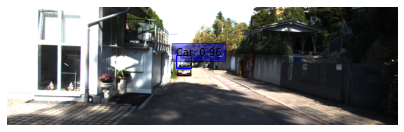

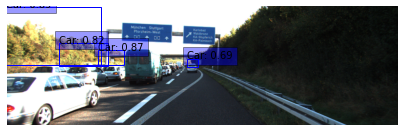

In [37]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# 8-9. 프로젝트: 자율주행 보조 시스템 만들기

먼저 주요 라이브러리 버전을 확인해봅시다.

In [68]:
import tensorflow as tf
import cv2

print(tf.__version__)
print(cv2.__version__)

2.8.0
4.1.2


# 1. 자율주행 시스템 만들기

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

In [56]:
img_path = '/content/drive/MyDrive/아이펠/GOING DEEPER/data/object_detection/data/stop_1.png'

def self_drive_assist(model, img_path, car_size=300, visualize=True):
    image = cv2.imread(img_path) # 이미지 읽기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.asarray(image)

    input_tensor = tf.convert_to_tensor(image) # 텐서
    
    image = tf.cast(input_tensor, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    if class_names.count('Pedestrian')>0:
        return 'Stop'

    for box in detections.nmsed_boxes[0][:num_detections]:
        x1, y1, x2, y2 = box
        w, h = (x2-x1) * ratio , (y2-y1) * ratio
        print(w, h, ratio)

        if car_size <= w or car_size <= h:
            return 'Stop'

    return 'Go'

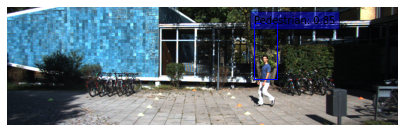

Stop


In [57]:
print(self_drive_assist(model, img_path))

# 2. 자율주행 시스템 평가하기

아래 `test_system()` 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [73]:
import os
from PIL import Image
import glob

def test_system(func):
    
    score = 0
    answer = ['Stop', 'Go']

    for file_name in glob.iglob(dir_path+'*.png'):
        # glob.iglob()를 사용하면 모든 경로가 나온다.
        pred = self_drive_assist(model=model, img_path=file_name)
        file_name= file_name.replace('/content/drive/MyDrive/아이펠/GOING DEEPER/data/object_detection/data/', '')
        
        if file_name[0]=='s':
            a = answer[0]
        else:
            a = answer[1]

        print(file_name)
        print(f'prediction: {pred}, answer: {a}\n')   
            
        if pred == a:
            score += 10
       
    print(f"결과: {score}점입니다.")

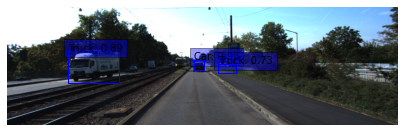

tf.Tensor(37.779667, shape=(), dtype=float32) tf.Tensor(34.56471, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(185.3903, shape=(), dtype=float32) tf.Tensor(114.75166, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(67.85609, shape=(), dtype=float32) tf.Tensor(36.044483, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
go_1.png
prediction: Go, answer: Go



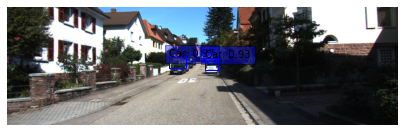

tf.Tensor(63.48244, shape=(), dtype=float32) tf.Tensor(39.630245, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(45.516453, shape=(), dtype=float32) tf.Tensor(44.230515, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
go_2.png
prediction: Go, answer: Go



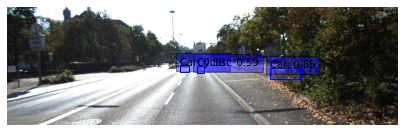

tf.Tensor(34.20491, shape=(), dtype=float32) tf.Tensor(24.459972, shape=(), dtype=float32) tf.Tensor(1.0890523, shape=(), dtype=float32)
tf.Tensor(112.704285, shape=(), dtype=float32) tf.Tensor(40.458553, shape=(), dtype=float32) tf.Tensor(1.0890523, shape=(), dtype=float32)
tf.Tensor(24.869797, shape=(), dtype=float32) tf.Tensor(24.093887, shape=(), dtype=float32) tf.Tensor(1.0890523, shape=(), dtype=float32)
go_3.png
prediction: Go, answer: Go



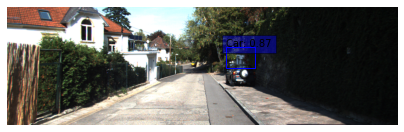

tf.Tensor(106.99228, shape=(), dtype=float32) tf.Tensor(78.78016, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
go_4.png
prediction: Go, answer: Go



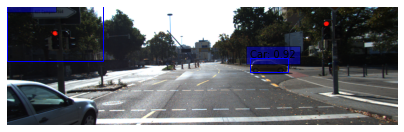

tf.Tensor(359.6533, shape=(), dtype=float32) tf.Tensor(204.37881, shape=(), dtype=float32) tf.Tensor(1.0890523, shape=(), dtype=float32)
stop_3.png
prediction: Stop, answer: Stop



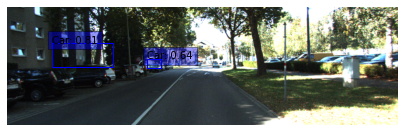

tf.Tensor(223.71709, shape=(), dtype=float32) tf.Tensor(85.9276, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(51.26012, shape=(), dtype=float32) tf.Tensor(34.330715, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
go_5.png
prediction: Go, answer: Go



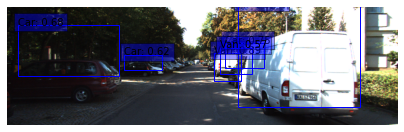

tf.Tensor(99.63714, shape=(), dtype=float32) tf.Tensor(101.92917, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(447.65833, shape=(), dtype=float32) tf.Tensor(373.88297, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
stop_4.png
prediction: Stop, answer: Stop



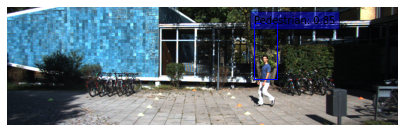

stop_1.png
prediction: Stop, answer: Stop



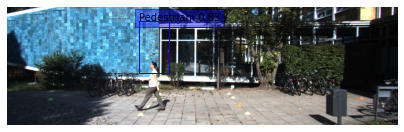

stop_2.png
prediction: Stop, answer: Stop



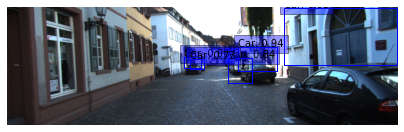

tf.Tensor(59.701237, shape=(), dtype=float32) tf.Tensor(40.18676, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(140.19745, shape=(), dtype=float32) tf.Tensor(87.997894, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
tf.Tensor(412.81122, shape=(), dtype=float32) tf.Tensor(211.94806, shape=(), dtype=float32) tf.Tensor(1.0732689, shape=(), dtype=float32)
stop_5.png
prediction: Stop, answer: Stop

결과: 100점입니다.


In [74]:
test_system(self_drive_assist)

# 회고

## 공부한 내용

### 1. bbox 시각화 하는 방법

Exploration 15에서 ocr 관련 프로젝트를 했었는데, 그 당시 naver의 Clova OCR을 사용해 보았는데 json타입의 출력물이 나와서 시각화를 잘 하지 못했다.<br>
그게 너무 마음에 걸렸지만 다시 볼 시간이 없었는데, 이번 프로젝트를 하면서 bbox를 시각화하는 코드를 ocr을 시각화 하는 데 사용할 수 있을것 같다는 생각이 들었다!🎉<br>
마침 going deeper 11-12가 ocr 프로젝트기 때문에 미리 생각해 두려고 한다.

<br>

```
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()
```
👆 위의 코드에서 아이디어를 얻었다!

<br>

- json이 key-value의 쌍으로 이루어져 있는데, dict타입으로 변형 후, 위의 for문과 같이 `print(list(example.keys()))`를 사용해 볼 예정
- bbox 시각화 함수 코드도 이번 노드에 구현되어 있으니, 사용해 보자! (`def visualize_bbox(input_image, object_bbox)`함수 참고)

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.|KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.|
|2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.|바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.|
|3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.|테스트 수행결과 90% 이상의 정확도를 보였다|

- 자율주행 시스템이 100점 만점이 나왔다!
- 그런데 자동차나 사람이 미묘하게 (또는 완전히) anchor box에 들어가지 않아서, 혹시 학습 에폭을 늘리면 더 성능이 좋아지지 않을까 추측해봤는데 학습시간이 너무 길어서 해보지 못했다.

## 어려웠던 점

- 나름대로 이론을 이해하고 들어갔는데도 코드가...ㅎㅎ....
- 저 많은 코드를 다 이해하고 프로젝트 코드를 스스로 짜야했는데, 실력이 부족한 관계로 많이 힘들었다.....
- 코드가 ㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎ
- cv-07 노드에서는 갓드류 Ng에게 이론 설명을 떠맡기시던 상권님ㅎㅎㅎㅎㅎㅎㅎ 그래요 상권님보다 갓드류가 더 설명 잘하시죠 현.명.하시네요!